# 5.2 Семинар: Реализация сверточного слоя

## Задача 1

In [ ]:
import torch

# Создаем входной массив из двух изображений RGB 3*3
input_images = torch.tensor(
      [[[[0,  1,  2],
         [3,  4,  5],
         [6,  7,  8]],

        [[9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]],


       [[[27, 28, 29],
         [30, 31, 32],
         [33, 34, 35]],

        [[36, 37, 38],
         [39, 40, 41],
         [42, 43, 44]],

        [[45, 46, 47],
         [48, 49, 50],
         [51, 52, 53]]]])


def get_padding2d(input_images):
    n, m, w, h = input_images.size()
    res = torch.empty((n, m, w+2, h+2), dtype=torch.float32)
    for i in range(n):
        for j in range(m):
            img = input_images[i][j] 
            size_w = img.size()[1]
            zeros = torch.zeros([1,size_w], dtype=torch.float32)
            img = torch.cat([zeros, img])
            img = torch.cat([img, zeros])
            size_h = img.size()[0]
            zeros = torch.zeros([size_h,1], dtype=torch.float32)
            img = torch.cat([zeros, img],1)
            img = torch.cat([img, zeros],-1)
            res[i][j] = img
    padded_images = res
    return padded_images


correct_padded_images = torch.tensor(
       [[[[0.,  0.,  0.,  0.,  0.],
          [0.,  0.,  1.,  2.,  0.],
          [0.,  3.,  4.,  5.,  0.],
          [0.,  6.,  7.,  8.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0.,  9., 10., 11.,  0.],
          [0., 12., 13., 14.,  0.],
          [0., 15., 16., 17.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0., 18., 19., 20.,  0.],
          [0., 21., 22., 23.,  0.],
          [0., 24., 25., 26.,  0.],
          [0.,  0.,  0.,  0.,  0.]]],


        [[[0.,  0.,  0.,  0.,  0.],
          [0., 27., 28., 29.,  0.],
          [0., 30., 31., 32.,  0.],
          [0., 33., 34., 35.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0., 36., 37., 38.,  0.],
          [0., 39., 40., 41.,  0.],
          [0., 42., 43., 44.,  0.],
          [0.,  0.,  0.,  0.,  0.]],

         [[0.,  0.,  0.,  0.,  0.],
          [0., 45., 46., 47.,  0.],
          [0., 48., 49., 50.,  0.],
          [0., 51., 52., 53.,  0.],
          [0.,  0.,  0.,  0.,  0.]]]])

# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
print(torch.allclose(get_padding2d(input_images), correct_padded_images))

True


## Задача 2

https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d

In [ ]:
import numpy as np

def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
    w = 1 + int((input_matrix_shape[2] + 2*padding - kernel_size) / stride)
    h = 1 + int((input_matrix_shape[3] + 2*padding - kernel_size) / stride)
    out_shape = [input_matrix_shape[0], out_channels, w, h]
    return out_shape

print(np.array_equal(
    calc_out_shape(input_matrix_shape=[2, 3, 10, 10],
                   out_channels=10,
                   kernel_size=3,
                   stride=1,
                   padding=0),
    [2, 10, 8, 8]))

# ... и ещё несколько подобных кейсов

True


## Задача 3

### В этом шаге вам предлагается изучить код для проверки.

In [ ]:
import torch
from abc import ABC, abstractmethod

# абстрактный класс для сверточного слоя
class ABCConv2d(ABC):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def set_kernel(self, kernel):
        self.kernel = kernel

    @abstractmethod
    def __call__(self, input_tensor):
        pass


# класс-обертка над torch.nn.Conv2d для унификации интерфейса
class Conv2d(ABCConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size,stride, padding=0,bias=False)

    def set_kernel(self, kernel):
        self.conv2d.weight.data = kernel

    def __call__(self, input_tensor):
        return self.conv2d(input_tensor)

# функция, создающая объект класса cls и возвращающая свертку от input_matrix
def create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_matrix):
    out_channels = kernel.shape[0]
    in_channels = kernel.shape[1]
    kernel_size = kernel.shape[2]

    layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride)
    layer.set_kernel(kernel)

    return layer(input_matrix)


# Функция, тестирующая класс conv2d_cls.
# Возвращает True, если свертка совпадает со сверткой с помощью torch.nn.Conv2d.
def test_conv2d_layer(conv2d_layer_class, batch_size=2, input_height=4, input_width=4, stride=2):

    kernel = torch.tensor([[[[0., 1, 0],   [1,  2, 1],  [0,  1, 0]],
                            [[1, 2, 1],    [0, 3, 3],   [0, 1, 10]],
                            [[10, 11, 12], [13, 14, 15],[16, 17, 18]]]])
    
    in_channels = kernel.shape[1]

    input_tensor = torch.arange(0, 
                                batch_size * in_channels * input_height * input_width,
                                out=torch.FloatTensor()).reshape(batch_size, 
                                in_channels, input_height, input_width)

    print(kernel, in_channels, input_tensor, sep = '\n' + '-'*50 + '\n')

    custom_conv2d_out = create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_tensor)

    conv2d_out = create_and_call_conv2d_layer(Conv2d, stride, kernel, input_tensor)

    return torch.allclose(custom_conv2d_out, conv2d_out) and (custom_conv2d_out.shape == conv2d_out.shape)

print(test_conv2d_layer(Conv2d))

tensor([[[[ 0.,  1.,  0.],
          [ 1.,  2.,  1.],
          [ 0.,  1.,  0.]],

         [[ 1.,  2.,  1.],
          [ 0.,  3.,  3.],
          [ 0.,  1., 10.]],

         [[10., 11., 12.],
          [13., 14., 15.],
          [16., 17., 18.]]]])
--------------------------------------------------
3
--------------------------------------------------
tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]],

         [[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]]],


        [[[48., 49., 50., 51.],
          [52., 53., 54., 55.],
          [56., 57., 58., 59.],
          [60., 61., 62., 63.]],

         [[64., 65., 66., 67.],
          [68., 69., 70., 71.],
          [72., 73., 74., 75.],
          [76., 77., 78., 79

### Переиспользуем код с предыдущего шага для проверки своей реализации сверточного слоя.

Рассмотрим свертку батча из одного однослойного изображения $3*3$ с ядром из одного фильтра $2*2$, $stride = 1$, то есть, на выходе должна получиться одна матрица 2*2. Строго записанная размерность выхода равна ($1$ - изображений в батче, $1$ - количество фильтров в ядре, $2$ - высота матрицы выхода, $2$ - ширина матрицы выхода).

На каждой итерации цикла фильтр умножается попиксельно на часть изображения, а потом 4 получившиеся числа складываются - получается один пиксель выхода.

Требуемое количество итераций для данного случая - $4$, так как может быть 2 положения ядра и $2$ по вертикали, общее число итераций - произведение количеств положений, то есть в данном случае $2*2 = 4$.

Давайте перейдем от простого случая к общему.

Если бы изображение было многослойным, например трехслойное - RGB, значит, фильтры в ядре тоже должны быть трехслойные. Каждый слой фильтра попиксельно умножается на соответствующий слой исходного изображения. То есть в данном случае после умножения получилось бы $4*3 = 12$ произведений, результаты которых складываются, и получается значение выходного пикселя.

Если бы фильтров в ядре было больше одного, то добавился бы внешний цикл по фильтрам, внутри которого мы считаем свертку для каждого фильтра.

Если бы во входном батче было более $1$ изображения, то добавился бы еще один внешний цикл по изображениям в батче.

Напоминание: во всех шагах этого урока мы считаем bias в сверточных слоях нулевым.

На этом шаге требуется реализовать сверточный слой через циклы.

Обратите внимание, что в коде рассматривается общий случай - батч на входе не обязательно состоит из одного изображения, в ядре несколько слоев.

In [ ]:
kernel = torch.tensor([[[[0., 1, 0],   [1,  2, 1],  [0,  1, 0]],
                        [[1, 2, 1],    [0, 3, 3],   [0, 1, 10]],
                        [[10, 11, 12], [13, 14, 15],[16, 17, 18]]]])
in_channels = kernel.shape[1]
batch_size=2
input_height=4
input_width=4
stride = 2
start = 0
end = batch_size * in_channels * input_height * input_width
# arange - тензор со значениями из интервала [start,end) c шагом step
input_tensor = torch.arange(start, end, out = torch.FloatTensor())
input_tensor = input_tensor.reshape(batch_size, in_channels, input_height, input_width)

In [ ]:
import torch
from abc import ABC, abstractmethod

def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
    batch_size, channels_count, input_height, input_width = input_matrix_shape
    output_height = (input_height + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    output_width = (input_width + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    return batch_size, out_channels, output_height, output_width

class ABCConv2d(ABC):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def set_kernel(self, kernel):
        self.kernel = kernel

    @abstractmethod
    def __call__(self, input_tensor):
        pass

class Conv2d(ABCConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                      stride, padding=0, bias=False)
    def set_kernel(self, kernel):
        self.conv2d.weight.data = kernel

    def __call__(self, input_tensor):
        return self.conv2d(input_tensor)

conv2d_out = create_and_call_conv2d_layer(Conv2d, stride, kernel, input_tensor)
conv2d_out

tensor([[[[ 5252.]]],


        [[[12596.]]]], grad_fn=<ConvolutionBackward0>)

In [ ]:
def create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_matrix):
    out_channels = kernel.shape[0]
    in_channels = kernel.shape[1]
    kernel_size = kernel.shape[2]
    layer = conv2d_layer_class(in_channels, out_channels, kernel_size, stride)
    layer.set_kernel(kernel)
    print('layer = ', layer)
    print('layer.set_kernel(kernel) = ', layer.set_kernel(kernel))
    return layer(input_matrix)

In [ ]:
def test_conv2d_layer(conv2d_layer_class, batch_size=2, input_height=4, input_width=4, stride=2):
    kernel = torch.tensor([[[[0.,1,0],[1,2,1],[0,1,0]],[[1,2,1],[0,3,3],[0,1,10]],[[10,11,12],[13,14,15],[16,17,18]]]])
    in_channels = kernel.shape[1]
    start = 0
    end = batch_size * in_channels * input_height * input_width
    # arange - тензор со значениями из интервала [start,end) c шагом step
    input_tensor = torch.arange(start, end, out = torch.FloatTensor())
    input_tensor = input_tensor.reshape(batch_size, in_channels, input_height, input_width)
    custom_conv2d_out = create_and_call_conv2d_layer(conv2d_layer_class, stride, kernel, input_tensor)
    conv2d_out = create_and_call_conv2d_layer(Conv2d, stride, kernel, input_tensor)
    return torch.allclose(custom_conv2d_out, conv2d_out) and (custom_conv2d_out.shape == conv2d_out.shape)

In [ ]:
kernel

tensor([[[[ 0.,  1.,  0.],
          [ 1.,  2.,  1.],
          [ 0.,  1.,  0.]],

         [[ 1.,  2.,  1.],
          [ 0.,  3.,  3.],
          [ 0.,  1., 10.]],

         [[10., 11., 12.],
          [13., 14., 15.],
          [16., 17., 18.]]]])

In [ ]:
input_tensor

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]],

         [[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]]],


        [[[48., 49., 50., 51.],
          [52., 53., 54., 55.],
          [56., 57., 58., 59.],
          [60., 61., 62., 63.]],

         [[64., 65., 66., 67.],
          [68., 69., 70., 71.],
          [72., 73., 74., 75.],
          [76., 77., 78., 79.]],

         [[80., 81., 82., 83.],
          [84., 85., 86., 87.],
          [88., 89., 90., 91.],
          [92., 93., 94., 95.]]]])

In [ ]:
def calc_out_shape(input_matrix_shape, out_channels, kernel_size, stride, padding):
    batch_size, channels_count, input_height, input_width = input_matrix_shape
    output_height = (input_height + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    output_width = (input_width + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    return batch_size, out_channels, output_height, output_width

# Сверточный слой через циклы.
class Conv2dLoop(ABCConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        # padding=0, bias=False

    def set_kernel(self, kernel):
        self.kernel = kernel

    def __call__(self, input_tensor):
        size = input_tensor.size()
        print('size = ', size)
        out_shape = calc_out_shape(input_matrix_shape = input_tensor.size(), 
                              out_channels = self.out_channels, 
                              kernel_size = self.kernel_size,
                              stride = self.stride, padding = 0)
        out_w = out_shape[2]
        out_h = out_shape[3]
        output_tensor = []
        for batch in range(size[0]): # Для каждого изображения из батча
            for channel in range(size[1]): # Для каждого канала из изображения
                rgb = [[0],[0],[0]]
                for height in range(out_h): #size[2]):
                    for width in range(out_w): # size[3]):
                        # print('input_tensor = \n', input_tensor[batch][channel])
                        section = input_tensor[batch][channel]\
                                                [height*stride : height*stride + self.kernel_size, \
                                                 width*stride : width*stride +  self.kernel_size]
                        # print('section = \n', section)
                        ker = self.kernel[0][channel]
                        # print('kernel = \n', ker)
                        res = (section * ker).sum()
                rgb[channel] = res
            print('rgb = ', rgb)
            output_tensor.append(sum(rgb))
        print('output_tensor = \n', output_tensor)



conv2d_out = create_and_call_conv2d_layer(Conv2dLoop, stride, kernel, input_tensor)
conv2d_out       

layer =  <__main__.Conv2dLoop object at 0x7f3fa5844090>
layer.set_kernel(kernel) =  None
size =  torch.Size([2, 3, 4, 4])
rgb =  [[0], [0], tensor(4740.)]


TypeError: ignored

In [ ]:
conv2d_out = create_and_call_conv2d_layer(Conv2d, stride, kernel, input_tensor)
conv2d_out

In [ ]:
# # output_tensor = # Напишите в этом месте вычисление свертки с использованием циклов.
        # return output_tensor

# Корректность реализации определится в сравнении со стандартным слоем из pytorch.
# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
print(test_conv2d_layer(Conv2dLoop))

# 5.6 Семинар: Распознавание рукописных чисел свёрточной нейросетью LeNet

In [2]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets

In [4]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
len(y_train), len(y_test)

(60000, 10000)

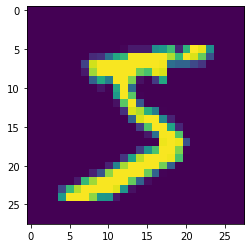

tensor(5)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [8]:
X_train.shape

torch.Size([60000, 28, 28])

In [9]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [10]:
X_train.shape # (N, C, H, W)

torch.Size([60000, 1, 28, 28])

In [11]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # 28*28
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2) 
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        # 14*14
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        # растянули форвардом изображение в один вектор
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        # 4ех мерный тензор -> первая размерность отвечает за размерность батча
        # преобразование тензора к нужной размерности
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        # размер батча, 400

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [13]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [14]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9750)
tensor(0.9828)
tensor(0.9859)
tensor(0.9874)
tensor(0.9888)
tensor(0.9881)
tensor(0.9853)
tensor(0.9884)
tensor(0.9887)
tensor(0.9882)


In [15]:
lenet5.forward(X_test)

tensor([[-1.3961,  0.2686,  1.6183,  ..., 13.6442, -2.4500,  2.1866],
        [ 1.2312, -1.2524, 14.6658,  ..., -2.7414,  1.8738, -4.0142],
        [-3.1090, 13.7151, -1.4544,  ..., -0.5432,  2.9941, -3.4365],
        ...,
        [-4.1479, -1.3929, -2.4224,  ...,  1.9677,  1.2219,  3.1864],
        [-1.9013, -3.1979, -4.9605,  ..., -5.5046,  2.3760, -2.1897],
        [ 1.1020, -4.5753, -0.5759,  ..., -8.8576,  0.0549, -2.7940]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

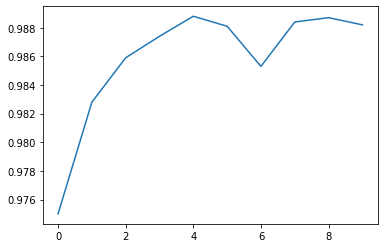

In [17]:
plt.plot(test_accuracy_history)

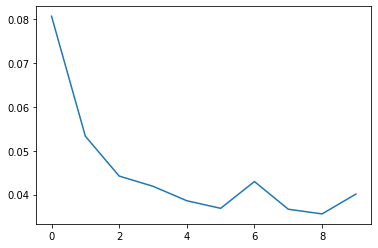

In [16]:
plt.plot(test_loss_history);

In [16]:
# loss хранит весь граф !
# сверточные NN плохо переобучаются